# RWSLFP/TKLFP comparison

In [12]:
# preamble:
import brian2.only as b2
from brian2 import np
import matplotlib.pyplot as plt
import cleo
from cleo import ephys
import cleo.utilities

# the default cython compilation target isn't worth it for
# this trivial example
b2.prefs.codegen.target = "numpy"
b2.seed(17570111)
np.random.seed(17570111)
rng = np.random.default_rng(17570111)

cleo.utilities.style_plots_for_paper()

# colors
c = {
    "light": "#df87e1",
    "main": "#C500CC",
    "dark": "#8000B4",
    "exc": "#d6755e",
    "inh": "#056eee",
    "accent": "#36827F",
}

## Network setup

First we need a point neuron simulation to approximate the LFP for.
Here we adapt a balanced E/I network implementation [from the Neuronal Dynamics textbook](https://neuronaldynamics-exercises.readthedocs.io/en/latest/_modules/neurodynex3/brunel_model/LIF_spiking_network.html#simulate_brunel_network), using some parameters from [Mazzoni, Lindén et al., 2015](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004584).

In [13]:
n_exc = 800
n_inh = None  # None = N_excit / 4
n_ext = 100
connection_probability = 0.2
w0 = 0.07 * b2.nA
g = 4
synaptic_delay = 1 * b2.ms
poisson_input_rate = 220 * b2.Hz
w_ext = 0.091 * b2.nA
v_rest = -70 * b2.mV
v_reset = -60 * b2.mV
firing_threshold = -50 * b2.mV
membrane_time_scale = 20 * b2.ms
Rm = 100 * b2.Mohm
abs_refractory_period = 2 * b2.ms

if n_inh is None:
    n_inh = int(n_exc / 4)
N_tot = n_exc + n_inh
if n_ext is None:
    n_ext = int(n_exc * connection_probability)
if w_ext is None:
    w_ext = w0

J_excit = w0
J_inhib = -g * w0

lif_dynamics = """
    dv/dt = (-(v-v_rest) + Rm*(I_exc + I_ext + I_gaba)) / membrane_time_scale : volt (unless refractory)
    I_gaba : amp
    I_exc : amp
    I_ext : amp
"""

neurons = b2.NeuronGroup(
    N_tot,
    model=lif_dynamics,
    threshold="v>firing_threshold",
    reset="v=v_reset",
    refractory=abs_refractory_period,
    method="linear",
)
neurons.v = (
    np.random.uniform(
        v_rest / b2.mV, high=firing_threshold / b2.mV, size=(n_exc + n_inh)
    )
    * b2.mV
)
cleo.coords.assign_coords_rand_cylinder(
    neurons, (0, 0, 700), (0, 0, 900), 250, unit=b2.um
)

exc = neurons[:n_exc]
inh = neurons[n_exc:]

syn_eqs = """
    dI_syn_syn/dt = (s - I_syn_syn)/tau_dsyn : amp (clock-driven)
    I_TYPE_post = I_syn_syn : amp (summed)
    ds/dt = -s/tau_rsyn : amp (clock-driven)
"""

exc_synapses = b2.Synapses(
    exc,
    target=neurons,
    model=syn_eqs.replace("TYPE", "exc"),
    on_pre="s += w",
    delay=synaptic_delay,
    namespace={"tau_rsyn": 0.4 * b2.ms, "tau_dsyn": 2 * b2.ms, "w": J_excit},
)
exc_synapses.connect(p=connection_probability)

inh_synapses = b2.Synapses(
    inh,
    target=neurons,
    model=syn_eqs.replace("TYPE", "gaba"),
    on_pre="s += w",
    delay=synaptic_delay,
    namespace={"tau_rsyn": 0.4 * b2.ms, "tau_dsyn": 2 * b2.ms, "w": J_inhib},
)
inh_synapses.connect(p=connection_probability)

ext_input = b2.PoissonGroup(n_ext, poisson_input_rate, name="ext_input")
ext_synapses = b2.Synapses(
    ext_input,
    target=neurons,
    model=syn_eqs.replace("TYPE", "ext"),
    on_pre="s += w",
    delay=synaptic_delay,
    namespace={"tau_rsyn": 0.4 * b2.ms, "tau_dsyn": 2 * b2.ms, "w": w_ext},
)
ext_synapses.connect(p=connection_probability)

net = b2.Network(
    neurons,
    exc_synapses,
    inh_synapses,
    ext_input,
    ext_synapses,
)
sim = cleo.CLSimulator(net)

## Electrode setup

In [14]:
elec_coords = cleo.ephys.linear_shank_coords(1 * b2.mm, channel_count=10)
elec_coords = cleo.ephys.tile_coords(
    elec_coords, num_tiles=3, tile_vector=(0, -500, 0) * b2.um
)
probe = cleo.ephys.Probe(elec_coords)

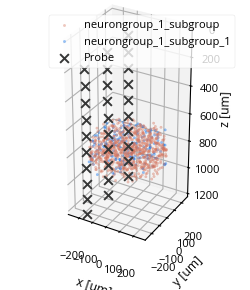

In [31]:
fig, ax = cleo.viz.plot(
    exc,
    inh,
    colors=[c["exc"], c["inh"]],
    zlim=(0, 1200),
    devices=[probe],
    scatterargs={"alpha": 0.4, "rasterized": True, "s": 3},
    figsize=(3, 3),
)
fig.savefig("img/fig/tklfp-rwslfp-3d.svg")

In [16]:
mua = ephys.MultiUnitActivity(
    r_perfect_detection=0.05 * b2.mm,
    r_half_detection=0.1 * b2.mm,
)
ss = ephys.SortedSpiking(0.05 * b2.mm, 0.1 * b2.mm)
tklfp = ephys.TKLFPSignal()

In [17]:
import wslfp

rwslfp = ephys.RWSLFPSignalFromSpikes(syn_delay=synaptic_delay)

In [18]:
probe.add_signals(
    mua,
    ss,
    tklfp,
    rwslfp,
)

sim.set_io_processor(cleo.ioproc.RecordOnlyProcessor(sample_period_ms=1))
sim.inject(
    probe,
    exc,
    # for TKLFPSignal:
    tklfp_type="exc",
    # for RWSLFPSignalFromSpikes:
    ampa_syns=[
        # want only synapses onto pyramidal cells
        (exc_synapses[f"j < {n_exc}"]),
        (ext_synapses[f"j < {n_exc}"]),
    ],
    gaba_syns=[(inh_synapses[f"j < {n_exc}"])],
)
# we don't include ampa_syns, gaba_syns, Iampa_var_name, or Igaba_var_name since RWSLFP
# is only recorded from pyramidal cells
sim.inject(probe, inh, tklfp_type="inh")

CLSimulator(io_processor=RecordOnlyProcessor(sample_period_ms=1, sampling='fixed', processing='parallel'), devices={Probe(name='Probe', save_history=True, signals=[MultiUnitSpiking(name='MultiUnitSpiking', brian_objects={<SpikeMonitor, recording from 'spikemonitor_15'>, <SpikeMonitor, recording from 'spikemonitor_9'>}, probe=..., r_perfect_detection=50. * umetre, r_half_detection=100. * umetre, cutoff_probability=0.01), SortedSpiking(name='SortedSpiking', brian_objects={<SpikeMonitor, recording from 'spikemonitor_10'>, <SpikeMonitor, recording from 'spikemonitor_16'>}, probe=..., r_perfect_detection=50. * umetre, r_half_detection=100. * umetre, cutoff_probability=0.01), TKLFPSignal(name='TKLFPSignal', brian_objects={<SpikeMonitor, recording from 'spikemonitor_11'>, <SpikeMonitor, recording from 'spikemonitor_17'>}, probe=..., uLFP_threshold_uV=0.001, _lfp_unit=uvolt), RWSLFPSignalFromSpikes(name='RWSLFPSignalFromSpikes', brian_objects={<SpikeMonitor, recording from 'spikemonitor_12'>, 

## Run simulation and plot results

In [19]:
sim.reset()
sim.run(1 * b2.second)

INFO       No numerical integration method specified for group 'synapses_3', using method 'exact' (took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'exact' (took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'exact' (took 0.00s). [brian2.stateupdaters.base.method_choice]


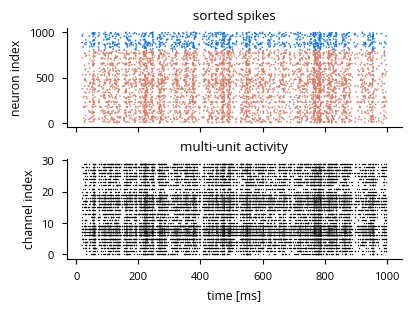

In [54]:
from matplotlib.colors import ListedColormap

fig, axs_psd = plt.subplots(2, 1, sharex=True, figsize=(4, 3), layout="constrained")

# assuming all neurons are detectable for c=ss.i >= n_e to work
# in practice this will often not be the case and we'd have to map
# from probe index to neuron group index using ss.i_probe_by_i_ng.inverse
exc_inh_cmap = ListedColormap([c["exc"], c["inh"]])
axs_psd[0].scatter(
    ss.t_ms, ss.i, marker=".", c=ss.i >= n_exc, cmap=exc_inh_cmap, s=3, rasterized=True
)
axs_psd[0].set(title="sorted spikes", ylabel="neuron index")

axs_psd[1].scatter(mua.t_ms, mua.i, marker=".", s=2, c="k", rasterized=True)
axs_psd[1].set(title="multi-unit activity", ylabel="channel index", xlabel="time [ms]")
fig.savefig("img/fig/tklfp-rwslfp-spikes.svg")

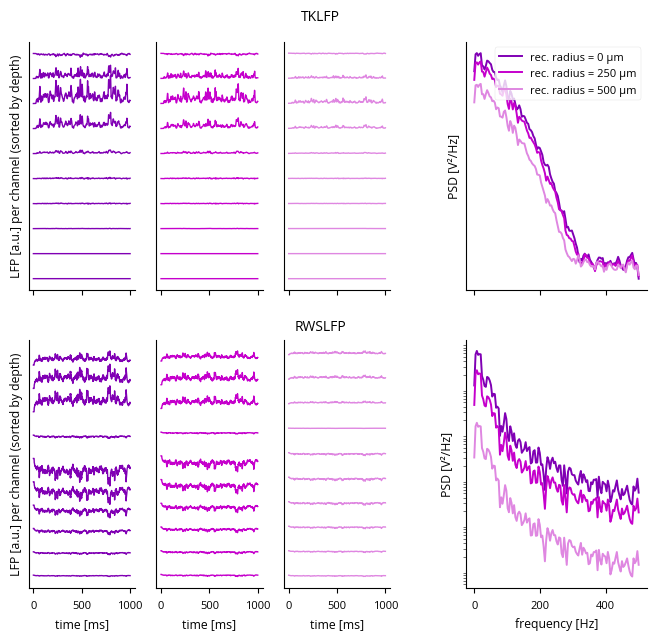

In [53]:
from scipy.signal import welch

n_shanks = 3
fig = plt.figure(figsize=(7, 6.5))
subfigs = fig.subfigures(1, 2, width_ratios=[2, 1])
axs_lfp = subfigs[0].subplots(2, n_shanks, sharex=True)
axs_psd = subfigs[1].subplots(2, 1, sharey=False, sharex=True)


def plot_lfp(t_ms, lfp, axs, title=None):
    n_contacts_per_shank = 10
    for i, color, ax in zip(range(n_shanks), [c["dark"], c["main"], c["light"]], axs):
        lfp_for_shank = lfp[
            :, i * n_contacts_per_shank : (i + 1) * n_contacts_per_shank
        ]
        ax.plot(
            t_ms,
            lfp_for_shank + np.arange(n_contacts_per_shank) * 0.9 * np.abs(lfp.max()),
            c=color,
            lw=1,
            rasterized=True,
        )
        ax.set(yticks=[])

    axs[0].set(ylabel="LFP [a.u.] per channel (sorted by depth)")
    if title:
        axs[1].set(title=title)
        # axs[1].text(
        #     0.5, 1.1, title, ha="center", va="bottom", transform=axs[1].transAxes
        # )


for i, signal in enumerate([tklfp, rwslfp]):
    plot_lfp(signal.t_ms, signal.lfp, axs_lfp[i, :], title="")
for ax in axs_lfp[-1, :]:
    ax.set(xlabel="time [ms]")


def plot_psd(lfp, ax, fs=1000, title=None):
    for i_shank, color in enumerate([c["dark"], c["main"], c["light"]]):
        f, p = welch(lfp[:, i_shank * 10 : (i_shank + 1) * 10].T, fs=fs)
        ax.semilogy(
            f,
            p.T.mean(axis=1),
            c=color,
            label=f"rec. radius = {i_shank * 250} µm",
            rasterized=True,
        )
    ax.set(ylabel="PSD [V²/Hz]", yticks=[])
    if title:
        ax.set(title=title)


fig.text(0.5, 1, "TKLFP", ha="center", va="top")
fig.text(0.5, 0.5, "RWSLFP", ha="center", va="bottom")
# make room for titles
subplots_adjust_kwargs = dict(top=0.95)
for sf in subfigs:
    sf.subplots_adjust(**subplots_adjust_kwargs)

plot_psd(tklfp.lfp, axs_psd[0], title="")
plot_psd(rwslfp.lfp, axs_psd[1], title="")
axs_psd[0].legend()
axs_psd[1].set(xlabel="frequency [Hz]")
fig.savefig("img/fig/tklfp-rwslfp-lfp-psd.svg")